In [1]:
#Vtk generation
import flopy
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata

# load simulation
simName = 'mf6Sim' ## Org
modelName = 'mf6Model' ## Org
modelWs = 'modelFiles' ## Org
sim = flopy.mf6.MFSimulation.load(sim_name=modelName, version='mf6', ## Org
                             exe_name='bin/mf6.exe', ## Org
                             sim_ws=modelWs) ## Org

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package evt...
    loading package drn...
    loading package oc...
  loading solution package mf6model...


In [2]:
gwf = sim.get_model('mf6model')

headObj = gwf.output.head()
heads = headObj.get_data()
waterTable = flopy.utils.postprocessing.get_water_table(heads)

In [5]:
# Get DISV grid geometry
disv = gwf.modelgrid
x, y = disv.xcellcenters, disv.ycellcenters  # 1D arrays, len = ncells

# Interpolate to regular grid for raster
grid_res = 50  # meters per pixel
xi = np.arange(x.min(), x.max(), grid_res)
yi = np.arange(y.min(), y.max(), grid_res)
xi, yi = np.meshgrid(xi, yi)

zi = griddata(
    points=(x, y), values=waterTable,
    xi=(xi, yi),
    method="linear"
)

# Set up transform for rasterio
transform = from_origin(xi.min(), yi.min(), grid_res, -grid_res)

# Export to GeoTIFF
with rasterio.open(
    "rst/waterTable3.tif",
    "w",
    driver="GTiff",
    height=zi.shape[0],
    width=zi.shape[1],
    count=1,
    dtype=zi.dtype,
    crs="EPSG:32718",  # <-- Change to your CRS
    transform=transform,
) as dst:
    dst.write(zi, 1)

print("✅ Exported water table as GeoTIFF.")

✅ Exported water table as GeoTIFF.


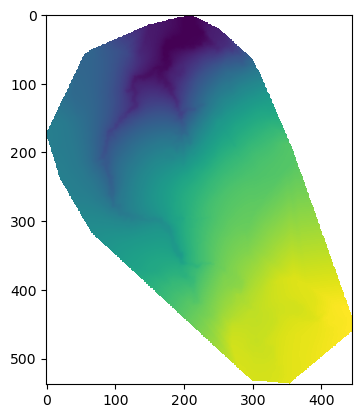

In [4]:
import matplotlib.pyplot as plt
plt.imshow(zi)